In [1]:
import re 
from pattern.fr import conjugate, lemma, parse, parsetree,pluralize, singularize
from collections import defaultdict
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import wordcloud
import spacy
import pylab
import hunspell
import operator
import random
import math

In [2]:
#charge le modèle de langue
nlp = spacy.load('fr_core_news_sm')
h = hunspell.HunSpell('/usr/share/hunspell/fr.dic', '/usr/share/hunspell/fr.aff')

In [3]:
stopwords=["tel","tels","telles","telle","celui","celle","ceux","certaines","certains",',','"','(',')',"lui","s’","d’","s'","se","n'","j'","l'",'l’',"d'","qu'",'leurs','toutes',"c'",'dès','etc','y','avoir','lesquelles','chacun','oui','non','ou','ne','par','plus','moins','tout','tous','faire','qui','que','pour','dans','sur','faut','il','de','des','les','la','le','du','à','et','on','un','une','au','aux','nos','son','sa','en','avec','pas','']
#ajoute à la liste des stopwords ceux trouvés sur ce site
#https://www.ranks.nl/stopwords/french
stop=open('stopwords.txt', 'r',encoding='utf-8')
for line in stop :
    line=line.strip('\ufeff')
    stopwords.append(line.strip('\n'))
stop.close()
#print(stopwords)

In [4]:
#renvoie liste de tuples (mot,tag)
#query = parse(txt)
def convert_tag_format(query): 
    word = query.split(' ')
    postag = [(x.split('/')[0], x.split('/')[1]) for x in word]
    return postag 

In [5]:
#renvoie liste de tuples (mot,chunk, chunkbis)
def convert_chunk_format(query): 
    word = query.split(' ')
    postag = [(x.split('/')[0], x.split('/')[2],x.split('/')[3]) for x in word]
    return postag 

In [6]:
#renvoie liste de tuples (mot,tag) + phrase taggée brut (ex : Il/PRP/B-NP/O faut/VB/B-VP/O)
#mot/tag/chunk/O tag (= outside) means that the word is not part of a chunk.
def get_pos_tags(text): 
    tagged_sent = parse(text)
    return convert_tag_format(tagged_sent), tagged_sent

In [7]:
def normalise(word):
    word = word.lower()
    return word

In [8]:
#conditions for acceptable word: length, stopword
def acceptable_word(word):
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords and lemma(word.lower()) not in stopwords)
    return accepted

In [9]:
#return ex : {'NP': ['il', 'les abattoirs'], 'VP': ['faut fermer']}
#extract entity from BIO encoding 
def extract_entity(filetext):
    last_entity = '' 
    last_tag = '' 
    mention2entities = {} 
    for line in filetext.split('\n'): 
        line = line.strip() 
        if line == '': 
            continue
        line_split = line.split('\t')
        if re.search('B-', line_split[1]): 
            if last_entity != '': 
                if not last_tag in mention2entities:
                    mention2entities[last_tag] = [] 
                mention2entities[last_tag].append(last_entity.strip())
            last_entity = line_split[0] + ' '
            last_tag = line_split[1][2:] 
        elif re.search('I-', line_split[1]): 
            last_entity += line_split[0] + ' '
    if last_entity != '': 
        if not last_tag in mention2entities:
            mention2entities[last_tag] = [] 
        mention2entities[last_tag].append(last_entity.strip())
    return mention2entities

In [10]:
#phrase2consider=liste (ex : ['NP', 'ADJP'])
#tagged_sent = phrase taggée brut (ex : Il/PRP/B-NP/O faut/VB/B-VP/O)
#mention2entities = dico (ex : {'NP': ['il', 'les abattoirs'], 'VP': ['faut fermer']})

#renvoie les entités présentes pour des types de phrase/groupe donnés, ex VP et NP etc
def get_entities_from_phrase(tagged_sent, phrase2consider): 
    word = tagged_sent.split(' ')
    bio_tags = [normalise(x.split('/')[0])+ '\t'+ x.split('/')[2] for x in word]
    bio_text = '\n'.join(bio_tags)
    mention2entities = extract_entity(bio_text)
    
    ## strip off unacceptable words 
    _mention2entities = {} 
    for mention in mention2entities: 
        if not mention in phrase2consider: 
            continue
        _mention2entities[mention] = [] 
        for entity in mention2entities[mention]: 
            _entity = ' '.join([word for word in entity.split(' ') if acceptable_word(word)]).strip()
            if _entity != '': 
                _mention2entities[mention].append(_entity)
    entities = []
    for mention in _mention2entities: 
        entities.extend(_mention2entities[mention])
    return entities

In [11]:
#renvoie liste de keywords, ici considéré par défaut comme entités dans NP et ADJP
def get_keywords(text, phrase2consider=['NP', 'ADJP']): 
    toRemove=[]
    try:
        postoks, tagged_sent = get_pos_tags(text)
        entities = get_entities_from_phrase(tagged_sent, phrase2consider)
        doc=nlp(text)
        if (phrase2consider==['NP', 'ADJP']) :
            for i in range(2,len(doc)) :
                tok=doc[i]
                beforetok=(doc[i-1])
                if i>2 : 
                    before2tok=(doc[i-2])
                if(tok.dep_=='nmod' and beforetok.dep_=='case' and tok.pos_=='NOUN' and tok.head.pos_=='NOUN'):
                    add=tok.head.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    ##toRemove.append(tok.text)
                    ##toRemove.append(tok.head.text)
                    entities.append(tok.head.text)
                    entities.append(tok.text)
                if(tok.dep_=='nmod' and before2tok.dep_=='case' and tok.pos_=='NOUN' and tok.head.pos_=='NOUN' and beforetok.pos_=='ADJ'):
                    add=tok.head.text+' '+before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    ##toRemove.append(tok.text)
                    ##toRemove.append(tok.head.text)
                    entities.append(tok.text)
                    entities.append(tok.head.text)
                if(tok.dep_=='appos' and tok.head.pos_=='NOUN') :
                    add=tok.head.text+' '+tok.text
                    entities.append(add)
                    ##toRemove.append(tok.text)
                    ##toRemove.append(tok.head.text)
                    entities.append(tok.text)
                    entities.append(tok.head.text)
                if(tok.pos_=='NOUN' and tok.dep_=='fixed' and beforetok.pos_=='ADP' and beforetok.dep_=='advmod' and beforetok.head.pos_=='NOUN') :
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    ##toRemove.append(tok.text)
                    ##toRemove.append(before2tok.text)
                    entities.append(tok.text)
                    entities.append(before2tok.text)
                if(tok.pos_=='NUM' and before2tok.pos_=='NOUN' and beforetok.pos_=='ADP' and beforetok.dep_=='case' and beforetok.head==tok):
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    ##toRemove.append(tok.text)
                    entities.append(tok.text)
                if(tok.pos_=='NOUN' and beforetok.pos_=='DET' and before2tok.pos_=='NOUN') :
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    entities.append(tok.text)
                    entities.append(before2tok.text)
                if( tok.text not in stopwords and tok.pos_=='ADJ' and beforetok.pos_=='ADJ' and before2tok.pos_=='NOUN' and tok.head==before2tok and beforetok.head==before2tok and tok.dep_=='amod' and beforetok.dep_=='amod') : 
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                if(tok.head.pos_=='NOUN' and tok.dep_=='amod' and tok.text not in stopwords ) :
                    if(tok.i < tok.head.i) :
                        toAdd=tok.text+' '+tok.head.text
                    else :
                        toAdd=tok.head.text+' '+tok.text
                    if(toAdd not in entities) :
                        entities.append(toAdd)
                    ##toRemove.append(tok.text)
                    ##toRemove.append(tok.head.text)
                    entities.append(tok.text)
                    entities.append(tok.head.text)
            for elt in toRemove :
                if elt in entities :
                    entities.remove(elt)
    except: 
        return []
    return list(set(entities))

In [ ]:
#renvoie liste de keywords, ici considéré par défaut comme entités dans NP et ADJP
#version qui renvoie les keywords en enlevant les mots seuls quand on prend un groupe 
#(exemple : si on prend produit de saison, on supprime produit et saison de la liste)

#version plus pratique pour représentation en wordcloud par exemple mais moins pour le taggage car certains sont manqués
#exemple : si dossiers mdph est pris 'mdph' est enlevé et donc la proposition ne sera pas taggée comme allocations
def get_keywords_small(text, phrase2consider=['NP', 'ADJP']): 
    toRemove=[]
    try:
        postoks, tagged_sent = get_pos_tags(text)
        entities = get_entities_from_phrase(tagged_sent, phrase2consider)
        doc=nlp(text)
        if (phrase2consider==['NP', 'ADJP']) :
            for i in range(2,len(doc)) :
                tok=doc[i]
                beforetok=(doc[i-1])
                if i>2 : 
                    before2tok=(doc[i-2])
                if(tok.dep_=='nmod' and beforetok.dep_=='case' and tok.pos_=='NOUN' and tok.head.pos_=='NOUN'):
                    add=tok.head.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    toRemove.append(tok.text)
                    toRemove.append(tok.head.text)
                if(tok.dep_=='nmod' and before2tok.dep_=='case' and tok.pos_=='NOUN' and tok.head.pos_=='NOUN' and beforetok.pos_=='ADJ'):
                    add=tok.head.text+' '+before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    toRemove.append(tok.text)
                    toRemove.append(tok.head.text)
                if(tok.dep_=='appos' and tok.head.pos_=='NOUN') :
                    add=tok.head.text+' '+tok.text
                    entities.append(add)
                    toRemove.append(tok.text)
                    toRemove.append(tok.head.text)
                if(tok.pos_=='NOUN' and tok.dep_=='fixed' and beforetok.pos_=='ADP' and beforetok.dep_=='advmod' and beforetok.head.pos_=='NOUN') :
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    toRemove.append(tok.text)
                    toRemove.append(before2tok.text)
                if(tok.pos_=='NUM' and before2tok.pos_=='NOUN' and beforetok.pos_=='ADP' and beforetok.dep_=='case' and beforetok.head==tok):
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    toRemove.append(tok.text)
                if(tok.pos_=='NOUN' and beforetok.pos_=='DET' and before2tok.pos_=='NOUN') :
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                    entities.append(tok.text)
                    entities.append(before2tok.text)
                if( tok.text not in stopwords and tok.pos_=='ADJ' and beforetok.pos_=='ADJ' and before2tok.pos_=='NOUN' and tok.head==before2tok and beforetok.head==before2tok and tok.dep_=='amod' and beforetok.dep_=='amod') : 
                    add=before2tok.text+' '+beforetok.text+' '+tok.text
                    entities.append(add)
                if(tok.head.pos_=='NOUN' and tok.dep_=='amod' and tok.text not in stopwords ) :
                    if(tok.i < tok.head.i) :
                        toAdd=tok.text+' '+tok.head.text
                    else :
                        toAdd=tok.head.text+' '+tok.text
                    if(toAdd not in entities) :
                        entities.append(toAdd)
                    toRemove.append(tok.text)
                    toRemove.append(tok.head.text)
            for elt in toRemove :
                if elt in entities :
                    entities.remove(elt)
    except: 
        return []
    return list(set(entities))

In [12]:
#créé une liste des propositions, de solutions, d'enjeux, des scores
data = pd.read_csv('handi_newrules2.csv', encoding='utf-8')
props=list(data['content'])
stakes=list(data['stake_one'])
kw=list(data['keywords_sansfiltre'])
solutions=list(data['solution_type_one'])
scores=list(data['score'])

In [13]:
def intersection(liste1, liste2): 
    res = [elt for elt in liste1 if elt in liste2] 
    return res 

In [14]:
#renvoie les propositions qui apparaissent si on créé/ajoute un keyword
def get_prop_create_kw(kw,props):
    kws=kw.split()
    res=[]
    res2=[]
    for prop in props : 
        words = prop.split()
        for i in range(len(words)) :
            words[i]=words[i].strip(',.());-')
        if(len(set(intersection(words,kws)))>= len(kws)) :
            res.append(intersection(words,kws))
            res2.append(prop)
    return res2

In [15]:
#créé des dictionnaires 
#proposition --> annotations, proposition --> annotations vp, keyword --> nb de propositions, keywordverbe --> nb de propositions
annotspattern=defaultdict(list)
annotslemme=defaultdict(list)
lemme2words=defaultdict(lambda:defaultdict(int))
vppattern=defaultdict(list)
keywordscount=defaultdict(int)
keywordsvpcount=defaultdict(int)
for prop in props:
    keywords=[]
    annotspattern[prop]+=get_keywords(prop,['NP', 'ADJP'])
    vppattern[prop]+=get_keywords(prop,['VP'])
    for entity in annotspattern[prop] : 
        i=0
        lemme=""
        for word in entity.split():
            try :
                lemme=lemme+h.stem(word)[0].decode('utf-8')+" "
            except IndexError :
                i+=1
                if(lemme=='') :
                    lemme=word+" "
                else :
                    lemme=lemme+word
                pass;
        if (lemme=='') :
            keywords.append(entity)
        else :
            lemme2words[lemme.strip()][entity]+=1
            keywords.append(lemme.strip())
    annotslemme[prop]=keywords

In [16]:
for prop in props:
    for i in range(len(annotspattern[prop])) :
        try :
            annotspattern[prop][i]=max(dict(lemme2words[annotslemme[prop][i]]).items(), key=operator.itemgetter(1))[0]
        except :
            continue
    for keyword in list(set(annotspattern[prop])) : 
        keywordscount[keyword]+=1
    for keywordvp in list(set(vppattern[prop])) :
        keywordsvpcount[keywordvp]+=1

In [18]:
sortedkeywordvpcounts=sorted(keywordsvpcount.items(), key=lambda x: x[1], reverse=True)
print(sortedkeywordvpcounts[:50])

[('permettre', 91), ('créer', 82), ('former', 66), ('faciliter', 59), ('mettre', 59), ('prendre', 52), ('donner', 52), ('arrêter', 52), ('favoriser', 47), ('aider', 46), ('augmenter', 44), ('sensibiliser', 42), ('développer', 41), ('rendre', 36), ('proposer', 35), ('obliger', 29), ('garantir', 29), ('reconnaître', 28), ('adapter', 27), ('adaptés', 26), ('revoir', 24), ('améliorer', 24), ('respecter', 23), ('travailler', 23), ('inclure', 22), ('informer', 21), ('accompagner', 20), ('valoriser', 19), ('appliquer', 17), ('délais', 17), ('adaptées', 17), ('aidant', 16), ('changer', 16), ('soutenir', 15), ('intégrer', 15), ('supprimer', 15), ('simplifier', 14), ('ouvrir', 14), ('accéder', 14), ('éviter', 13), ('pensions', 13), ('trouver', 13), ('réduire', 13), ('adapté', 13), ('puissent', 12), ('spécialisées', 12), ('penser', 12), ('embaucher', 12), ('écoute', 12), ('imposer', 12)]


In [30]:
for keyword in keywordsvpcount.keys() : 
    if len(keyword)>1 : 
        kw=nlp(keyword)
        for i in range(len(kw)) :
            if(kw[i].pos_!="VERB") :
                print(kw[i],kw[i].pos_)

épanouir ADJ
pleinement ADV
ensemble NOUN
puisse ADJ
adapte NOUN
puissent AUX
demande NOUN
frais NOUN
impose NOUN
droit NOUN
croient ADV
faux ADJ
pensions NOUN
mieux ADV
réservés ADJ
mieux ADV
permette NOUN
prises NOUN
dites AUX
exclure NOUN
favorise NOUN
hospitalisées ADJ
construire ADJ
rien PRON
adapté NOUN
donnent NOUN
mieux ADV
travaille NOUN
prise NOUN
simplifier ADJ
davantage ADV
aménagent NOUN
prioritairement ADJ
démarre NOUN
enfin ADV
délais NOUN
tolérants NOUN
perçoivent ADV
déjà ADV
iront ADV
cher ADJ
davantage ADV
utilisent ADV
montant NOUN
mieux ADV
enfin ADV
plutôt ADV
bien ADV
notifie NOUN
peuvent AUX
gagne ADJ
rapidement ADV
munis NOUN
réduite NOUN
vendent ADV
stigmatisent NOUN
bénéficie NOUN
souvent ADV
compris ADJ
facilement ADV
auprès ADP
respecte NOUN
davantage ADV
négocie NOUN
puissent AUX
base NOUN
partagent NOUN
profitent NOUN
rendent NOUN
exploitent ADV
plient ADV
vraiment ADV
vite ADV
multiplier NOUN
puissent AUX
interdépendants NOUN
aide NOUN
écoute NOUN
inclur

financièrement ADV
conduisent NOUN
expriment ADV
mieux ADV
traumatisées ADJ
mieux ADV
bien ADV
sente NOUN
bien ADV
durant ADP
progressivement ADV
régulièrement ADV
vraiment ADV
pourrait AUX
doivent AUX
participe NOUN
emmènent ADV
souvent ADV
obligés ADJ
facile ADJ
encaisse NOUN
devoir AUX
n NOUN
arrive ADJ
pouvant AUX
souvent ADV
autour ADV
mieux ADV
discrimine ADJ
habilité NOUN
licencient ADV
lourdement ADV
renouvelés ADJ
rompre ADJ
vécue ADV
puisse AUX
sérieusement ADV
puissent AUX
restent AUX
souvent ADV
enseignent NOUN
notamment ADV
beaucoup ADV
stricte ADJ
puissent AUX
déjà ADV
rien PRON
huma ADJ
quasi PRON
impossible ADJ
peuvent AUX
beaucoup ADV
bas NOUN
délais NOUN
auprès ADP
souple NOUN
équipé NOUN
puissent AUX
mieux ADV
vivre NOUN
pouvant AUX
auprès ADP
bien ADV
impliqués ADJ
sommes NOUN
prévue NOUN
disposent ADV
protège ADV
rien PRON
communique ADJ
souhaitant AUX
puisse AUX
agisse NOUN
suscitent ADV
prétendent ADV
inclus ADV
puissent AUX
librement ADV
souvent ADV
négligé ADJ


In [17]:
#ajout colonnes keywords à un fichier csv
"""l=[]
for prop in props : 
    kws=""
    for kw in annotspattern[prop]:
        kws+=kw+'|'
    l.append(kws.strip('|'))
data = pd.read_csv('handi_newrules2.csv', encoding='utf-8')
data = data.assign(keywords2_sansfiltre=l)
data.to_csv('handi_newrules2.csv',index=False)"""

In [75]:
#tester différence entre extraction get_keywords et det_keywords_small
d = pd.read_csv('handi_newrules2.csv', encoding='utf-8')
kw2=list(d['keywords2_sansfiltre'])
num=0
s=0
m=0
for i in range(len(props)) :
    if(kw[i]!=kw2[i] and not isinstance(kw[i],float) and not isinstance(kw2[i],float)) :
        ret=set(kw2[i].split('|'))-set(kw[i].split('|'))
        if len(ret)>m : 
            m=len(ret)
        s+=len(ret)
        num+=1
print(s/num)
print(m)

3.4977533699450825
11


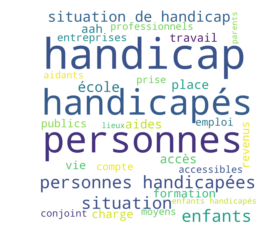

In [19]:
#wordcloud des keywords les plus présents
wordcloudkeyword = wordcloud.WordCloud(background_color="white",width=2500,height=2500, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(keywordscount)
plt.imshow(wordcloudkeyword,interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud.png")

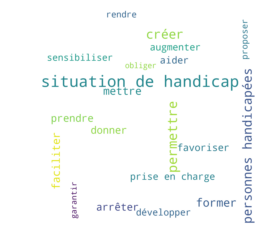

In [19]:
#wordcloud des keywords vp les plus présents
wordcloudkeyword = wordcloud.WordCloud(background_color="white",width=1500,height=1500, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(keywordsvpcount)
plt.imshow(wordcloudkeyword,interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
def get_keywords_count(subset):
    errors = []
    counts = defaultdict(int)
    for kws in subset['keywords'] :
        print((list(kws.split())))
        try:
            for kw in list(kws) :
                counts[kw] += 1
        except:
            errors.append(kws)
    if errors:
        print('Errors: %s' % "\n".join(errors))
    return pd.Series(counts)

In [21]:
def get_prop_with_kw(kw,props):
    l=[]
    for prop in props : 
        if kw in annotspattern[prop] :
            l.append(prop)
    return l

In [22]:
def get_prop_with_vp_kw(kw,props):
    l=[]
    for i in range(len(props)) : 
        if kw in vppattern[props[i]] :
            l.append((props[i],solutions[i]))
    return l

In [41]:
print("kw vp ?")
rep=input()
for prop,solution in get_prop_with_vp_kw(rep,props) :
    print(prop,solution)
print(len(get_prop_with_vp_kw(rep,props)))

kw vp ?
garantir
Il faut que l'AAH ne soit pas dépendante du revenu du conjoint.e, afin de garantir un minimum d'indépendance financière aux personnes handi réforme des politiques publiques
Il faut garantir une AAH, peut-être moindre si la personne travaille, mais fixe. C’est une compensation qui ne remplace pas le travail réforme des politiques publiques
Il faut garantir une réelle égalité des chances dès le plus jeune âge, à l'école. La loi de 2005-102 n'est pas appliquée dans sa globalité harmonisation
Il faut garantir aux handicapés la même durée de vie que les valides. Il faut préserver la vie des handicapés face aux lois Léonetti Claeys orientation de politique générale
Il faut garantir un accès pour toutes les personnes ayant un handicap, que ce soit dans la rue, les institutions, car ça peut être difficile aménagement des espaces
Il faut garantir plus de stabilité et de protection pour les travailleurs handicapés. Le handicap non visible est vite oublié au travail  réforme des 

In [23]:
def get_prop_with_word(word,props):
    l=[]
    for prop in props : 
        if word in prop.lower() :
            l.append(prop)
    return l

In [23]:
print("word ?")
rep=input()
for prop in get_prop_with_word(rep,props) :
    print(prop)
print(len(get_prop_with_word(rep,props)))

word ?
représentation
Il faut plus de représentations du handicap (politique, médias...)
Il faut des interventions dans les écoles pour travailler les représentations qui stigmatisent le handicap, notamment psychique 
Il faut sensibiliser l'ensemble des jeunes au handicap (moteur, sensoriel, psychique...), afin de changer les représentations actuelles 
Il faut plus de représentations positives, dynamiques de personnes porteuses de divers handicaps dans les médias
Il faut éduquer les plus jeunes et communiquer largement pour changer les représentations
Il faut créer une accessibilité universelle et inclusive, qui ne discrimine pas les PH et change les représentations sociales du handicap
Il faut obligation de représentation dans tous les domaines électifs publics, que les handicapés soient inclus dans tous les domaines
7


In [27]:
print("kw ?")
rep=input()
for prop in get_prop_with_kw(rep,props) :
    print(prop)
print(len(get_prop_with_kw(rep,props)))

kw ?
publics
Il faut mieux informer le public sur la santé mentale, pour changer les regards sur les personnes en situation de handicap psychique 
Il faut poser une date limite pour que tout commerce et tout établissement recevant du public soit aux normes d’accueil des PMR
Il faut que tous les services publics, écoles, magasins, etc soient munis d'ascenseurs, escalators ou rampe, pour un déplacement plus aisé 
Il faut faire attention à ne pas déléguer la gestion du handicap au privé, garder un service public dédié
Il faut qu'enfin les bâtiments publics se plient à l'obligation d'accès aux PMR. 10 ans de retard !
Il faut inclure des ergothérapeutes dans les projets d'aménagements d’espaces publics pour aller au delà des normes d’accessibilité fixées
Il faut sensibiliser davantage le public aux handicaps non visibles
Il faut un quota obligatoire avec pénalités, pour l'emploi d'handicapés dans tous les secteurs publics et privés
Il faut favoriser la mixité valides/handicapés dans les lie

In [25]:
s=0
props2rank=defaultdict(float)
for i in range (len(props)) :
    props2rank[data['content'][i]]=float(data['rank'][i])
    if float(data['rank'][i]) < 999 :
        s+=1
print(s)

181


In [35]:
#pourcentage pour props plébiscitées 
print("quels kws ?")
rep=input()
kws=[]
for word in rep.split(",") : 
    kws.append(word.strip())
res=[]
for i in range (len(kws)) :
    for prop in get_prop_with_kw(kws[i],props) :
        if props2rank[prop]<999 :
            res.append(prop)
print(len(set(res))/181*100)

quels kws ?
handicaps invisibles, dys, troubles dys
3.314917127071823


In [23]:
#pourcentage 
print("quels kws ?")
rep=input()
kws=[]
for word in rep.split(",") : 
    kws.append(word.strip())
res=[]
for i in range (len(kws)) :
    for prop in get_prop_with_kw(kws[i],props) :
        res.append(prop)
print(len(set(res))/len(props)*100)

quels kws ?
école, éducation nationale, avs, aesh, enseignants, élèves, classe, ime, établissements scolaires, scolarité, professeurs,université, scolarisation, langue des signes, entreprises, travail, emploi, travailleurs handicapés, esat, employeurs, rqth, embauche, temps partiel, aah, mdph, pch, conjoint, revenus, revenus du conjoint, retraite, seuil de pauvreté, allocation, revenu universel, transports, transports en commun, accessibles, accessibilité, lieux publics, prise en charge, aidants, aidants familiaux, handicaps invisibles, dys, troubles dys, regard
36.50022094564737


In [39]:
#tagger propositions (association keywords-->enjeux)

#ajout colonnes enjeu à un fichier csv
d= pd.read_csv('handi_newrules2.csv', encoding='utf-8')
p=list(d['content'])
k=list(d['keywords2_sansfiltre'])
l=[]
educ=["école","écoles","classes" ,"éducation nationale", "avs", "aesh", "enseignants", "élèves", "classe", "ime", "établissements scolaires", "scolarité", "professeurs","université", "scolarisation", "langue des signes"]
travail=["vie active","entreprises", "travail", "emploi","travailleurs handicapés", "esat", "employeurs", "rqth", "embauche", "temps partiel"]
alloc=["salaire du conjoint","aah", "mdph", "pch", "conjoint", "revenus", "revenus du conjoint", "retraite", "seuil de pauvreté", "allocation", "revenu universel"]
access=["transports", "transports en commun", "accessibles", "accessibilité", "lieux publics"]
charge=["prise en charge"]
aidant=["aidants","aidants familiaux"]
invisible=["handicaps invisibles","dys","troubles dys"]
regard=["regard"]
for i in range(len(p)) : 
    enjeu2countkw=defaultdict(int)
    if not isinstance(k[i],float) :
        for kw in k[i].split('|'):
            #print(k[i].split('|'))
            if kw in educ : 
                enjeu2countkw["éducation"]+=1
            if kw in travail : 
                enjeu2countkw["travail"]+=1
            if kw in alloc :
                enjeu2countkw["allocations et financier"]+=1
            if kw in access :
                enjeu2countkw["accessibilité et mobilité"]+=1
            if kw in charge :
                enjeu2countkw["prise en charge"]+=1
            if kw in aidant :
                enjeu2countkw["aidants"]+=1
            if kw in invisible : 
                enjeu2countkw["handicaps invisibles"]+=1
            if kw in regard : 
                enjeu2countkw["changement regard"]+=1
    if enjeu2countkw :
        if(len(enjeu2countkw)>1 and len(set(enjeu2countkw.values()))==1):
            num=random.randint(0,len(enjeu2countkw)-1)
            l.append(list(enjeu2countkw.items())[num][0])
        else : 
            l.append(max(enjeu2countkw.keys(), key=(lambda x: enjeu2countkw[x])))
    else : 
        l.append("")

data2=pd.read_csv('handi_newrules2.csv', encoding='utf-8')
data2 = data2.assign(stake_extrait_2=l)
data2.to_csv('handi_newrules2.csv',index=False)

In [77]:
#tester différence entre extraction get_keywords et det_keywords_small
data2=pd.read_csv('handi_newrules2.csv', encoding='utf-8')
data2 = data2[pd.notnull(data2['stake_extrait'])]
s1=list(data2['stake_extrait'])
s2=list(data2['stake_extrait_2'])
kws=list(data2['keywords_sansfiltre'])
kws2=list(data2['keywords2_sansfiltre'])
diff=0
for i in range(len(s1)) :
    if(s1[i]!=s2[i] and set(kws2[i].split('|'))-set(kws[i].split('|'))!=set() and set(kws2[i].split('|'))-set(kws[i].split('|'))!={"écoles"} and set(kws2[i].split('|'))-set(kws[i].split('|'))!={"classes"}): 
        diff+=1
        print(s1[i],s2[i])
        print(kws[i],'   ',kws2[i])
        print(set(kws2[i].split('|'))-set(kws[i].split('|')))
print(diff)

aidants travail
adaptation|personnes handicapées|aidants-familiaux|postes de travail|aidants familiaux|personnes en entreprise     adaptation|postes|travail|personnes handicapées|aidants-familiaux|entreprises|postes de travail|postes|travail|aidants familiaux|familiaux|aidants|personnes en entreprise|personnes|entreprises
{'postes', 'aidants', 'personnes', 'travail', 'entreprises', 'familiaux'}
accessibilité et mobilité éducation
loi|dérogations|écoles transports|accessibles|loi de 2015|obliger écoles     loi|dérogations|écoles transports|accessibles|loi de 2015|2015|obliger écoles|écoles|obliger
{'écoles', 'obliger', '2015'}
allocations et financier éducation
mdph|aesh|pps|cycles scolaires|ans     mdph|aesh|pps|cycles scolaires|an|scolaire|cycles
{'cycles', 'an', 'scolaire'}
prise en charge allocations et financier
démarches|mdph|différents organismes|demandes de prise|prise en charge     démarches|mdph|demande|prise|charge|différents organismes|demandes de prise|demande|prise|prise e

In [61]:
def get_props_with_stake(stake,props) :
    res=[]
    for i in range(len(p)) :
        if s[i]==stake : 
            res.append(p[i])
    return res

éducation                    281
travail                      245
allocations et financier     228
accessibilité et mobilité    140
aidants                       46
prise en charge               45
handicaps invisibles          31
changement regard             19
Name: stake_extrait_2, dtype: int64
1035


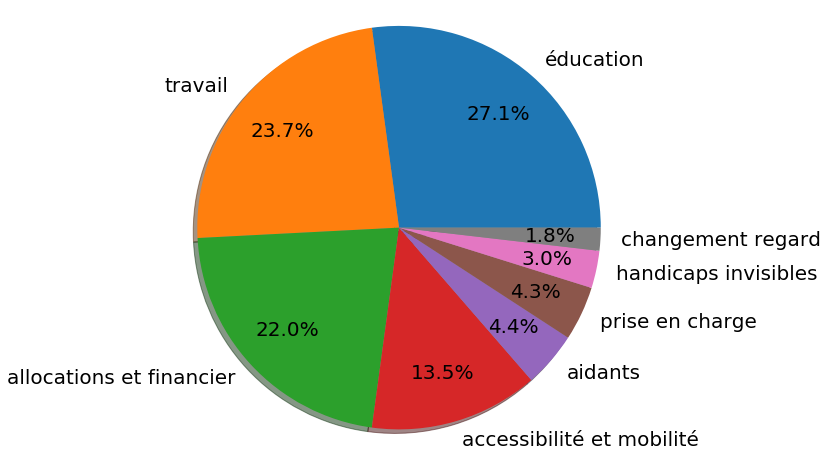

couverture : 45.73574900574458%


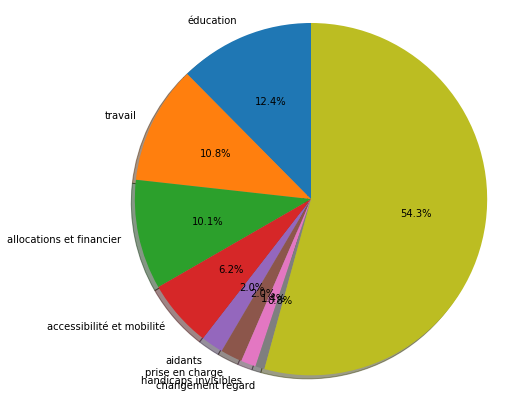

NameError: name 'get_props_with_stake' is not defined

In [40]:
d=pd.read_csv('handi_newrules2.csv', encoding='utf-8')
print(d['stake_extrait_2'].value_counts())

df=d['stake_extrait_2'].value_counts().to_frame()
listecount=[(str(x),int(y)) for x,y in df.itertuples()]
names=[x for x,y in listecount]
num=[y for x,y in listecount]
print(sum(num))
percent1=[y/sum(num)*100 for x,y in listecount]

fig2, ax2 = plt.subplots()
ax2.pie(percent1, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=0,textprops={'fontsize': 20}, pctdistance=0.75)
ax2.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(8,8)
#fig.savefig("piecharttrain.jpg")
plt.show()


percent=[y/len(props)*100 for x,y in listecount]
print("couverture : "+str(sum(percent))+"%")
percent.append(100-sum(percent))
names.append("")
fig1, ax1 = plt.subplots()
ax1.pie(percent, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()
        
percent2=[]
for name in names :
    res=[]
    for prop in get_props_with_stake(name,p) :
        if props2rank[prop]<999 :
            res.append(prop)
    percent2.append(len(res)/181*100)
print("couverture : "+str(sum(percent2))+"%")
percent2.append(100-sum(percent2))
names.append("")
fig3, ax3 = plt.subplots()
ax3.pie(percent2, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

In [3]:
#quand on part de fichier où on a déjà extrait les enjeux
###########################################################################################
###########################################################################################
###########################################################################################
data = pd.read_csv('handi_newrules2.csv', encoding='utf-8')
props=list(data['content'])
keywords=list(data['keywords'])
s=list(data['stake_extrait_2'])
keywordscount=defaultdict(int)
stake2keywordcount=defaultdict(lambda:defaultdict(int))
stakescount=defaultdict(int)
for i in range(len(props)) : 
    stake=s[i]
    stakescount[stake]+=1
    if not isinstance(keywords[i],float) :
        for kw in keywords[i].split('|'):
            stake2keywordcount[stake][kw]+=1
            keywordscount[kw]+=1

In [59]:
#renvoie une liste ordonnée des keywords les plus présents
sortedkeywordcounts=sorted(keywordscount.items(), key=lambda x: x[1], reverse=True)
print("NP, ADJP")
print(sortedkeywordcounts[:100])
print('\n')
#print("VP")
#print(sortedkeywordvpcounts[:20])

NP, ADJP
[('handicap', 260), ('personnes handicapées', 188), ('personnes', 171), ('situation de handicap', 136), ('handicapés', 126), ('aah', 95), ('école', 82), ('enfants', 77), ('conjoint', 58), ('enfants handicapés', 56), ('accès', 54), ('place', 53), ('entreprises', 51), ('prise en charge', 51), ('revenus', 48), ('mdph', 48), ('emploi', 42), ('travail', 39), ('loi', 38), ('aide', 37), ('pouvoir', 36), ('formation', 35), ('moyens', 35), ('revenus du conjoint', 35), ('travailleurs handicapés', 32), ('enseignants', 31), ('besoins', 30), ('accessibilité', 29), ('parents', 29), ('société', 28), ('compte', 26), ('droits', 26), ('vie', 26), ('handicaps invisibles', 26), ('calcul', 25), ('aidants', 25), ('accessibles', 24), ('retraite', 24), ('avs', 24), ('domicile', 23), ('lieu', 22), ('familles', 22), ('esat', 22), ('employeurs', 22), ('fauteuil', 22), ('inclusion', 21), ('regard', 20), ('public', 20), ('établissements', 20), ('structures', 19), ('charge', 19), ('personnel', 18), ('aidan

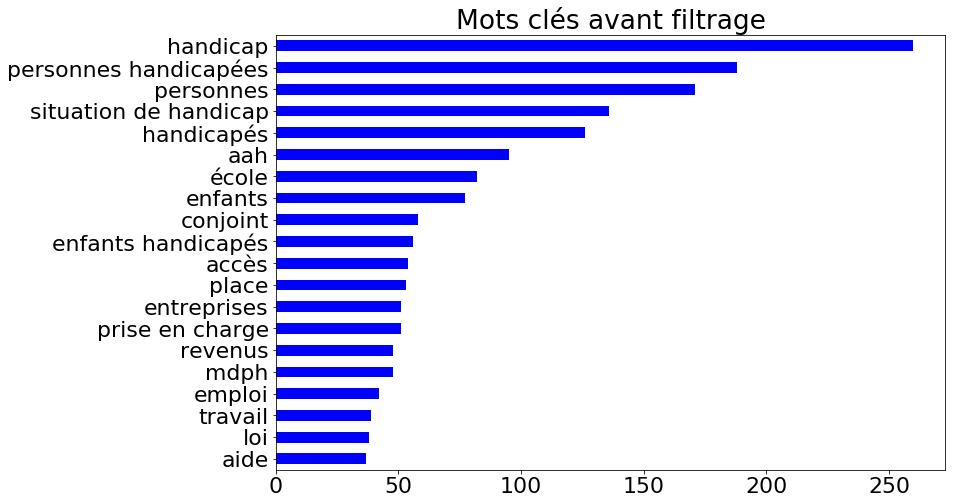

In [60]:
plt.rcParams.update({'font.size': 22})

counts=pd.DataFrame(sortedkeywordcounts)
ax = counts.head(20).plot(kind='barh',figsize=(12,8),color="b")
y=[x for x,y in sortedkeywordcounts]
ax.set_yticklabels(y)
ax.set_title("Mots clés avant filtrage")
ax.invert_yaxis()
ax.get_legend().remove()

In [20]:
#affiche le nombre de propositions et le pourcentage de propositions ayant au moins un keyword qui apparait x fois
print(len(props))
print("pourcentage de propositions ayant au moins un keyword qui apparait "+str(sortedkeywordcounts[50][1]) +" fois : ")
c=0
print(sortedkeywordcounts[50])
for prop in props :
    if len(set(annotspattern[prop]).intersection(set([a for a,b in sortedkeywordcounts[:50]]))):
        c+=1
print(c/len(props)*100) 

707
pourcentage de propositions ayant au moins un keyword qui apparait 5 fois : 
('application', 5)
62.94200848656294


In [ ]:
#garder tag ou pas ? 
for kw in [x for x,y in sortedkeywordcounts][:20] :
    print(kw)
    for prop in get_prop_with_kw(kw,props)[:8] :
        print(prop)
    print("faire de "+ kw +" un tag ? y/n")
    rep=input()
    if (rep=='y') : 
        print()
    else : 
        for prop in get_prop_with_kw(kw,props):
            annotspattern[prop].remove(kw)

In [28]:
print(sortedkeywordcounts[:150])
print(len(sortedkeywordcounts))
print('\n')
print("pourcentage de propositions ayant au moins un keyword qui apparait "+str(sortedkeywordcounts[50][1]) +" fois : ")
c=0
for prop in props :
    if len(set(annotspattern[prop]).intersection(set([a for a,b in sortedkeywordcounts[:50]]))):
        c+=1
print(c/len(props)*100) 

NameError: name 'sortedkeywordcounts2' is not defined

In [56]:
print("quels kws ?")
rep=input()
kws=[]
props2score=defaultdict(float)
for i in range (len(props)) :
    props2score[data['content'][i]]=float(data['score'][i])
for word in rep.split(",") : 
    kws.append(word.strip())
props_with_kws=[]
res=[]
for i in range (len(kws)) :
    for prop in get_prop_with_kw(kws[i],props) :
        props_with_kws.append(prop)
for prop in list(set(props_with_kws)) :
    res.append((prop,props2score[prop]))
print(sorted(res,key=lambda x : x[1],reverse=True)[:5])

quels kws ?
handicaps invisibles, dys, troubles dys
[('Il faut former les profs de façon obligatoire aux troubles Dys. ', 2.65748565778993), ('Il faut reconnaître le handicap invisible', 2.5119366062979904), ("Il faut sensibiliser les personnes et les professionnels sur les handicaps invisibles. Handicap n'est pas synonyme de fauteuil", 2.44042512267017), ('Il faut arrêter de mettre un fauteuil roulant pour parler du handicap et sensibiliser aux handicaps invisibles qui ne sont pas compris ', 2.39435075889208), ('Il faut former le personnel éducatif, notamment sur les handicaps invisibles. ', 2.1511156047391)]


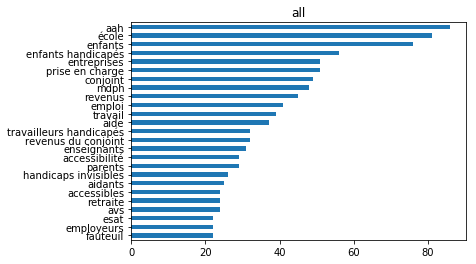

In [27]:
counts=pd.DataFrame(sortedkeywordcounts2)
ax = counts.head(25).plot(kind='barh', title='all')
y=[x for x,y in sortedkeywordcounts2]
ax.set_yticklabels(y)
ax.invert_yaxis()
ax.get_legend().remove()

In [29]:
def intersection_kws_props(kws,props) :
    res=[]
    for prop in get_prop_with_kw(kws[0],props) : 
        if (set(kws).issubset(set(annotspattern[prop]))) :
            res.append(prop)
    print(len(res))
    return res

In [37]:
#proposition par score descendant pour un keyword 
print("quel keyword ? ")
kw=input()
l=get_prop_with_kw(kw,props)
prop2score=defaultdict(float)
for i in range (len(props)) :
    prop2score[data['content'][i]]=float(data['score'][i])
res=[]
for prop in l :
    res.append((prop,prop2score[prop]))
print(sorted(res,key=lambda x : x[1],reverse=True)[:5])

quel keyword ? 
école
[('Il faut des interventions dans les écoles pour travailler les représentations qui stigmatisent le handicap, notamment psychique ', 3.11009042981444), ("Il faut parler des handicaps et des handicapés, visibles ou non, dès le premier âge à l'école. Il faut donc former les enseignants", 2.7271572126697405), ("Il faut revaloriser le métier d'AES dans les écoles, collèges, lycées, en créant plus de postes pour ces acteurs sociaux ", 2.67033093232908), ("Il faut que l'on ouvre vraiment l'école à tous les enfants, et que les professeurs aient une formation minimum ", 2.47731434770238), ('Il faut reconnaître le statut des AVS dans les écoles et le valoriser comme un véritable métier', 2.45832213622809)]


In [40]:
#répartition des enjeux pour les keywords les plus fréquents
solutionscount=defaultdict(int)
stakescount=defaultdict(int)
vp2solutioncount=defaultdict(lambda:defaultdict(int))
keyword2stakecount=defaultdict(lambda:defaultdict(int))
for i in range(len(props)) : 
    keyvp=[a for a,b in sortedkeywordvpcounts]
    keyw=[x for x,y in sortedkeywordcounts]
    for word in set(annotspattern[props[i]]) :
        if word in keyw :
            keyword2stakecount[word][stakes[i]]+=1
    for vb in set(vppattern[props[i]]) : 
        if vb in keyvp : 
            vp2solutioncount[vb][solutions[i]]+=1
    solutionscount[solutions[i]]+=1
    stakescount[stakes[i]]+=1

travailleurs handicapés
[(nan, 75.0), ('emploi et formation', 15.625), ('aides et allocations', 6.25), ('protection sociale et services publics', 3.125)]




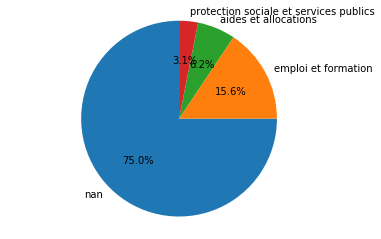

personnes handicapées
[(nan, 64.8936170212766), ('aides et allocations', 5.851063829787234), ('protection sociale et services publics', 4.787234042553192), ('emploi et formation', 4.25531914893617), ('droits et citoyenneté', 3.1914893617021276), ('accès aux infrastructures', 3.1914893617021276), ('mobilité', 3.1914893617021276), ('situation financière', 2.6595744680851063), ('regards et représentations', 1.5957446808510638), ('généralité', 1.5957446808510638), ('accompagnement', 1.5957446808510638), ('thème non mentionné', 1.0638297872340425), ('scolarité', 1.0638297872340425), ('logement', 0.5319148936170213), ('digital et numérique', 0.5319148936170213)]




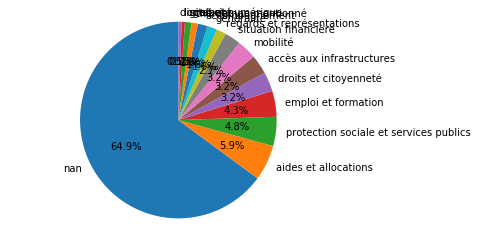

accès
[(nan, 68.51851851851852), ('scolarité', 7.4074074074074066), ('accès aux infrastructures', 3.7037037037037033), ('regards et représentations', 3.7037037037037033), ('mobilité', 3.7037037037037033), ('sport', 1.8518518518518516), ('protection sociale et services publics', 1.8518518518518516), ('emploi et formation', 1.8518518518518516), ('généralité', 1.8518518518518516), ('démarches administratives', 1.8518518518518516), ('aides et allocations', 1.8518518518518516), ('accès aux soins', 1.8518518518518516)]




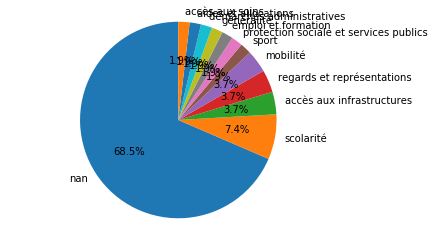

pouvoir
[(nan, 63.888888888888886), ('aides et allocations', 13.88888888888889), ('accès aux infrastructures', 8.333333333333332), ('mobilité', 5.555555555555555), ('sport', 2.7777777777777777), ('accompagnement', 2.7777777777777777), ('démarches administratives', 2.7777777777777777)]




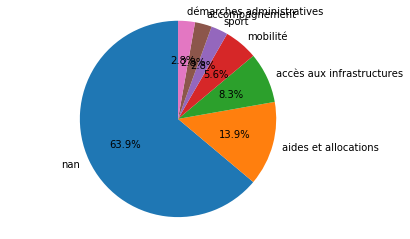

handicap
[(nan, 63.17829457364341), ('regards et représentations', 8.527131782945736), ('accompagnement', 5.038759689922481), ('emploi et formation', 4.263565891472868), ('scolarité', 3.875968992248062), ('accès aux infrastructures', 3.10077519379845), ('protection sociale et services publics', 1.937984496124031), ('généralité', 1.550387596899225), ('aides et allocations', 1.550387596899225), ('démarches administratives', 1.550387596899225), ('droits et citoyenneté', 1.1627906976744187), ('mobilité', 1.1627906976744187), ('thème non mentionné', 0.7751937984496124), ('culture et loisirs', 0.7751937984496124), ('sport', 0.3875968992248062), ('pathologies', 0.3875968992248062), ('accès aux soins', 0.3875968992248062), ('situation financière', 0.3875968992248062)]




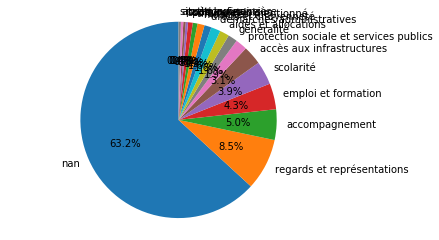

personnes
[(nan, 62.048192771084345), ('emploi et formation', 5.421686746987952), ('regards et représentations', 4.216867469879518), ('accompagnement', 4.216867469879518), ('aides et allocations', 3.614457831325301), ('mobilité', 3.614457831325301), ('généralité', 3.0120481927710845), ('démarches administratives', 3.0120481927710845), ('droits et citoyenneté', 2.4096385542168677), ('accès aux soins', 1.8072289156626504), ('accès aux infrastructures', 1.8072289156626504), ('protection sociale et services publics', 1.8072289156626504), ('logement', 1.2048192771084338), ('situation financière', 1.2048192771084338), ('scolarité', 0.6024096385542169)]




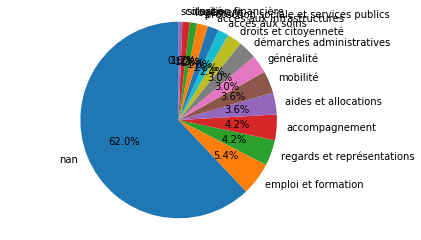

société
[(nan, 57.14285714285714), ('regards et représentations', 14.285714285714285), ('accès aux infrastructures', 10.714285714285714), ('scolarité', 7.142857142857142), ('généralité', 7.142857142857142), ('aides et allocations', 3.571428571428571)]




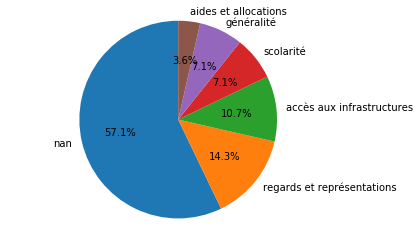

emploi
[(nan, 68.29268292682927), ('emploi et formation', 14.634146341463413), ('aides et allocations', 4.878048780487805), ('scolarité', 4.878048780487805), ('accompagnement', 2.4390243902439024), ('protection sociale et services publics', 2.4390243902439024), ('regards et représentations', 2.4390243902439024)]




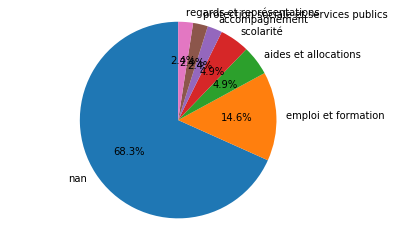

entreprises
[(nan, 72.54901960784314), ('emploi et formation', 23.52941176470588), ('accès aux infrastructures', 1.9607843137254901), ('accompagnement', 1.9607843137254901)]




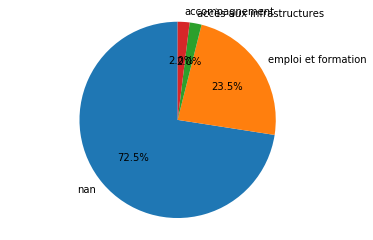

situation de handicap
[(nan, 67.91044776119402), ('emploi et formation', 8.955223880597014), ('accompagnement', 5.223880597014925), ('accès aux soins', 2.2388059701492535), ('droits et citoyenneté', 2.2388059701492535), ('regards et représentations', 1.4925373134328357), ('généralité', 1.4925373134328357), ('logement', 1.4925373134328357), ('scolarité', 1.4925373134328357), ('démarches administratives', 1.4925373134328357), ('aides et allocations', 1.4925373134328357), ('situation financière', 0.7462686567164178), ('protection sociale et services publics', 0.7462686567164178), ('culture et loisirs', 0.7462686567164178), ('digital et numérique', 0.7462686567164178), ('accès aux infrastructures', 0.7462686567164178), ('mobilité', 0.7462686567164178)]




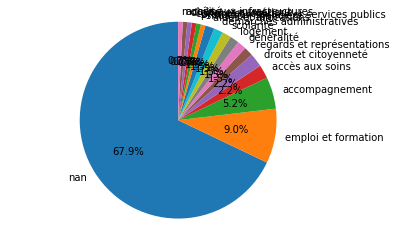

formation
[(nan, 54.285714285714285), ('emploi et formation', 28.57142857142857), ('accompagnement', 8.571428571428571), ('scolarité', 8.571428571428571)]




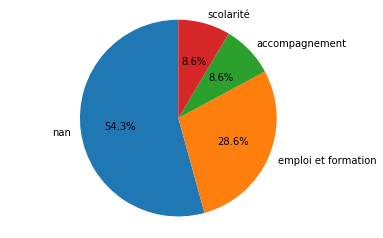

moyens
[(nan, 68.57142857142857), ('accompagnement', 5.714285714285714), ('scolarité', 5.714285714285714), ('protection sociale et services publics', 5.714285714285714), ('généralité', 2.857142857142857), ('regards et représentations', 2.857142857142857), ('situation financière', 2.857142857142857), ('démarches administratives', 2.857142857142857), ('accès aux infrastructures', 2.857142857142857)]




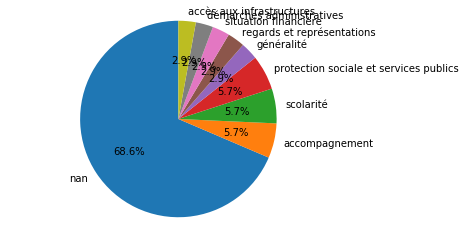

besoins
[(nan, 66.66666666666666), ('accompagnement', 16.666666666666664), ('généralité', 6.666666666666667), ('emploi et formation', 3.3333333333333335), ('protection sociale et services publics', 3.3333333333333335), ('scolarité', 3.3333333333333335)]




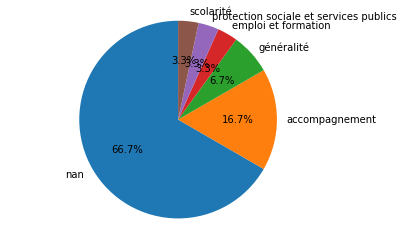

place
[(nan, 73.07692307692307), ('emploi et formation', 5.769230769230769), ('mobilité', 5.769230769230769), ('regards et représentations', 5.769230769230769), ('accompagnement', 3.8461538461538463), ('généralité', 1.9230769230769231), ('scolarité', 1.9230769230769231), ('accès aux infrastructures', 1.9230769230769231)]




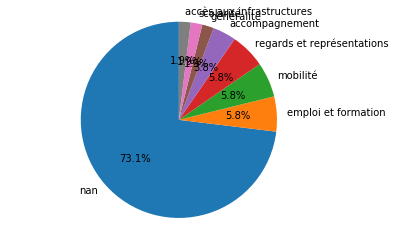

enfants handicapés
[(nan, 66.07142857142857), ('scolarité', 17.857142857142858), ('accompagnement', 8.928571428571429), ('emploi et formation', 1.7857142857142856), ('culture et loisirs', 1.7857142857142856), ('situation financière', 1.7857142857142856), ('mobilité', 1.7857142857142856)]




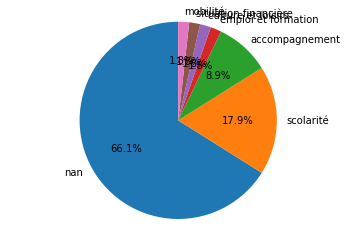

aide
[(nan, 59.45945945945946), ('accompagnement', 10.81081081081081), ('aides et allocations', 10.81081081081081), ('protection sociale et services publics', 8.108108108108109), ('mobilité', 5.405405405405405), ('généralité', 2.7027027027027026), ('accès aux soins', 2.7027027027027026)]




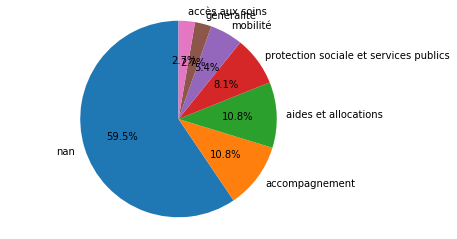

accessibilité
[('accès aux infrastructures', 68.96551724137932), (nan, 13.793103448275861), ('mobilité', 10.344827586206897), ('aides et allocations', 3.4482758620689653), ('accès aux soins', 3.4482758620689653)]




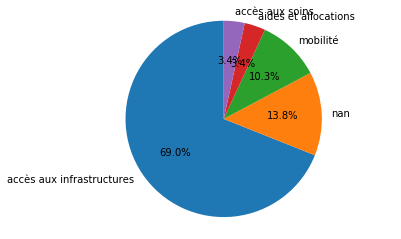

conjoint
[('aides et allocations', 63.26530612244898), (nan, 26.53061224489796), ('protection sociale et services publics', 6.122448979591836), ('situation financière', 2.0408163265306123), ('accès aux soins', 2.0408163265306123)]




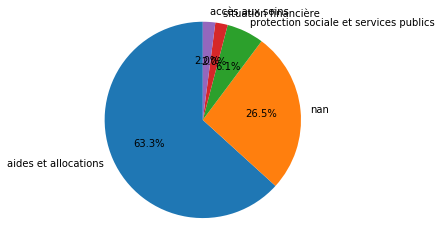

revenus du conjoint
[('aides et allocations', 75.0), (nan, 18.75), ('situation financière', 3.125), ('protection sociale et services publics', 3.125)]




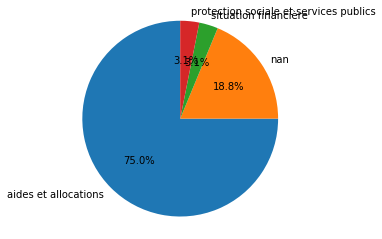

revenus
[('aides et allocations', 62.22222222222222), (nan, 26.666666666666668), ('situation financière', 6.666666666666667), ('protection sociale et services publics', 4.444444444444445)]




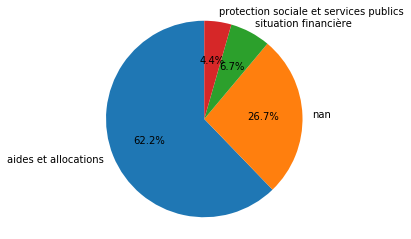

école
[(nan, 62.96296296296296), ('scolarité', 22.22222222222222), ('regards et représentations', 4.938271604938271), ('accompagnement', 3.7037037037037033), ('emploi et formation', 3.7037037037037033), ('accès aux infrastructures', 1.2345679012345678), ('protection sociale et services publics', 1.2345679012345678)]




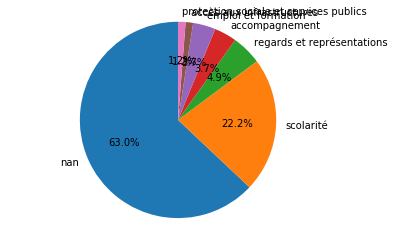

aah
[('aides et allocations', 73.25581395348837), ('situation financière', 8.13953488372093), ('protection sociale et services publics', 8.13953488372093), ('démarches administratives', 4.651162790697675), (nan, 3.488372093023256), ('emploi et formation', 1.1627906976744187), ('accès aux soins', 1.1627906976744187)]




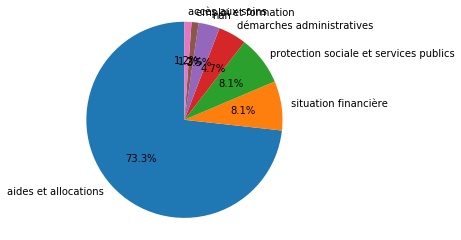

handicapés
[(nan, 64.46280991735537), ('accès aux infrastructures', 5.785123966942149), ('aides et allocations', 5.785123966942149), ('protection sociale et services publics', 3.3057851239669422), ('regards et représentations', 3.3057851239669422), ('droits et citoyenneté', 3.3057851239669422), ('emploi et formation', 2.479338842975207), ('démarches administratives', 2.479338842975207), ('situation financière', 2.479338842975207), ('professionnels et établissements de santé', 1.6528925619834711), ('culture et loisirs', 1.6528925619834711), ('généralité', 0.8264462809917356), ('accès aux soins', 0.8264462809917356), ('mobilité', 0.8264462809917356), ('logement', 0.8264462809917356)]




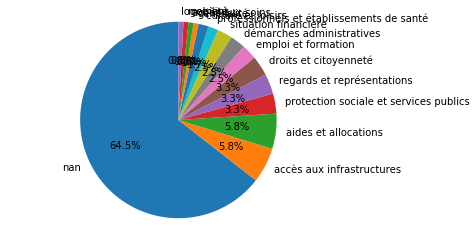

loi
[(nan, 45.94594594594595), ('accès aux infrastructures', 18.91891891891892), ('droits et citoyenneté', 13.513513513513514), ('mobilité', 5.405405405405405), ('emploi et formation', 5.405405405405405), ('thème non mentionné', 2.7027027027027026), ('scolarité', 2.7027027027027026), ('démarches administratives', 2.7027027027027026), ('généralité', 2.7027027027027026)]




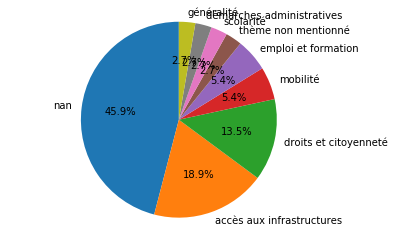

travail
[(nan, 56.41025641025641), ('emploi et formation', 17.94871794871795), ('protection sociale et services publics', 7.6923076923076925), ('accompagnement', 5.128205128205128), ('accès aux infrastructures', 5.128205128205128), ('regards et représentations', 2.564102564102564), ('aides et allocations', 2.564102564102564), ('logement', 2.564102564102564)]




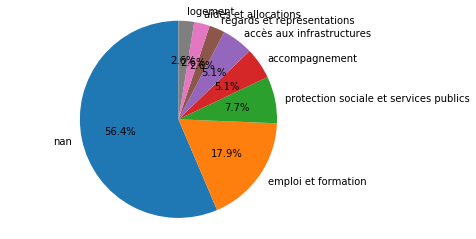

parents
[(nan, 68.96551724137932), ('accompagnement', 13.793103448275861), ('regards et représentations', 6.896551724137931), ('démarches administratives', 3.4482758620689653), ('scolarité', 3.4482758620689653), ('protection sociale et services publics', 3.4482758620689653)]




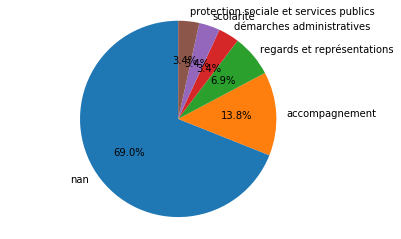

prise en charge
[(nan, 68.62745098039215), ('accès aux soins', 11.76470588235294), ('protection sociale et services publics', 7.8431372549019605), ('accompagnement', 5.88235294117647), ('généralité', 1.9607843137254901), ('démarches administratives', 1.9607843137254901), ('scolarité', 1.9607843137254901)]




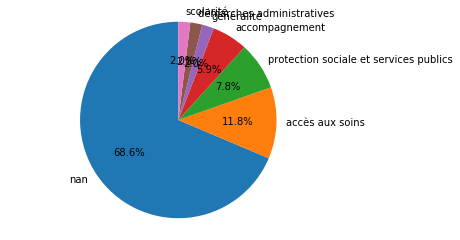

mdph
[('démarches administratives', 29.166666666666668), ('protection sociale et services publics', 29.166666666666668), (nan, 16.666666666666664), ('pathologies', 8.333333333333332), ('scolarité', 6.25), ('aides et allocations', 4.166666666666666), ('emploi et formation', 2.083333333333333), ('professionnels et établissements de santé', 2.083333333333333), ('droits et citoyenneté', 2.083333333333333)]




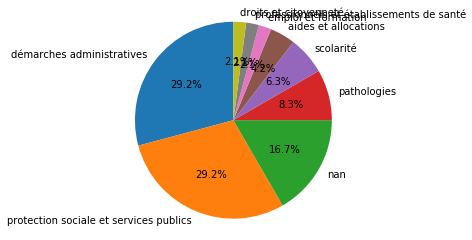

enseignants
[(nan, 67.74193548387096), ('scolarité', 25.806451612903224), ('regards et représentations', 3.225806451612903), ('accompagnement', 3.225806451612903)]




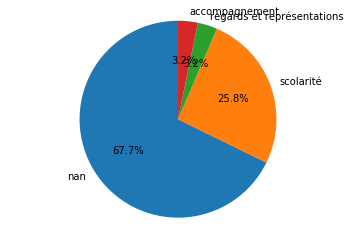

enfants
[(nan, 64.93506493506493), ('scolarité', 22.07792207792208), ('culture et loisirs', 2.5974025974025974), ('regards et représentations', 2.5974025974025974), ('accompagnement', 2.5974025974025974), ('emploi et formation', 1.2987012987012987), ('généralité', 1.2987012987012987), ('professionnels et établissements de santé', 1.2987012987012987), ('protection sociale et services publics', 1.2987012987012987)]




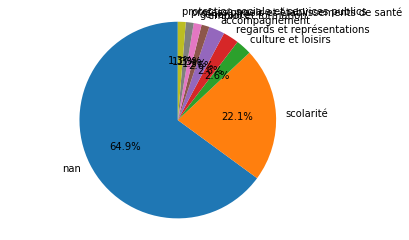

In [67]:
#répartition des enjeux pour les keywords les plus fréquents
for k,v in keyword2stakecount.items() : 
    print(k)
    somme=sum([y for x,y in keyword2stakecount[k].items()])
    tagparkeyword=[(x,(y/somme)*100) for x,y in keyword2stakecount[k].items()]
    sortedtagparkeyword=sorted(tagparkeyword, key=lambda x: x[1], reverse=True)
    print(sortedtagparkeyword)
    print('\n')
    labels=[x for x,y in sortedtagparkeyword]
    sizes=[y for x,y in sortedtagparkeyword]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [41]:
#répartition des enjeux pour un keyword donné
keyword2stakecount=defaultdict(lambda:defaultdict(int))
for i in range(len(props)) : 
    for word in set(annotspattern[props[i]]) :
        keyword2stakecount[word][stakes[i]]+=1

répartition pour quel keyword ?
pathologie
pathologie
[(nan, 100.0)]




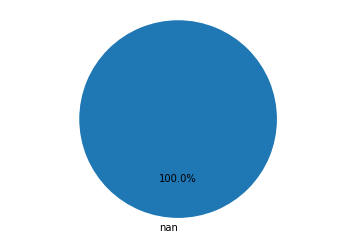

In [28]:
#répartition des enjeux pour un keyword donné
print("répartition pour quel keyword ?")
k=input()
print(k)
somme=sum([y for x,y in keyword2stakecount[k].items()])
tagparkeyword=[(x,(y/somme)*100) for x,y in keyword2stakecount[k].items()]
sortedtagparkeyword=sorted(tagparkeyword, key=lambda x: x[1], reverse=True)
print(sortedtagparkeyword)
print('\n')
labels=[x for x,y in sortedtagparkeyword]
sizes=[y for x,y in sortedtagparkeyword]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [35]:
#solutions les plus fréquentes pour les keywords vp les plus présents
for k,v in vp2solutioncount.items() : 
    print(k)
    sortedsolution=sorted(vp2solutioncount[k].items(), key=lambda x: x[1], reverse=True)
    print(sortedsolution)
    print('\n')

développer
[(nan, 25), ('réforme des politiques publiques', 5), ('orientation de politique générale', 4), ('aménagement des espaces', 2), ('harmonisation', 2), ('sensibilisation et communication', 2), ('budget et finances publiques', 1)]


aidant
[(nan, 14), ('réforme des politiques publiques', 2)]


pratiquer
[('orientation de politique générale', 1)]


épanouir pleinement
[('orientation de politique générale', 1)]


plaît
[('orientation de politique générale', 1), (nan, 1)]


favoriser
[(nan, 27), ('insertion', 6), ('réforme des politiques publiques', 5), ('sensibilisation et communication', 3), ('aménagement des espaces', 2), ('aides et subventions', 2), ('orientation de politique générale', 1), ('budget et finances publiques', 1)]


faciliter
[(nan, 36), ('insertion', 7), ('simplification', 6), ('réforme des politiques publiques', 3), ('orientation de politique générale', 2), ('aménagement des espaces', 2), ('sensibilisation et communication', 1), ('budget et finances publiques', 1

proposé
[(nan, 1)]


présent
[(nan, 1)]


mieux formé
[(nan, 1)]


acceptables
[(nan, 1)]


mieux formées
[(nan, 1)]


autonomiser
[(nan, 1)]


associée
[('aménagement des espaces', 1)]


souhaite
[(nan, 1)]


tenant
[(nan, 1)]


traitent
[(nan, 1)]


consultées
[(nan, 1)]


imposable
[(nan, 1)]


doublée
[('sensibilisation et communication', 1), ('réforme des politiques publiques', 1)]


dépénaliser
[(nan, 1)]


souhaitant accéder
[(nan, 1)]


mieux diffuser
[(nan, 1)]


contraints
[(nan, 1)]


publient
[(nan, 1)]


puissent devenir aidant
[(nan, 1)]


exigée
[(nan, 1)]


effectués
[(nan, 1)]


scolaires,souvent sacrifiés
[(nan, 1)]


ramener
[(nan, 1)]


agit
[(nan, 1)]


conjuguer
[(nan, 1)]


initier
[('sensibilisation et communication', 1)]


important
[(nan, 1)]


investissent
[(nan, 1)]


embaucher simplement
[('budget et finances publiques', 1)]


autonomes
[('budget et finances publiques', 1)]


mieux considérées
[(nan, 1)]


garantissent
[('réforme des politiques publiques', 

favoriser
[(nan, 27), ('insertion', 6), ('réforme des politiques publiques', 5), ('sensibilisation et communication', 3), ('aménagement des espaces', 2), ('aides et subventions', 2), ('orientation de politique générale', 1), ('budget et finances publiques', 1)]


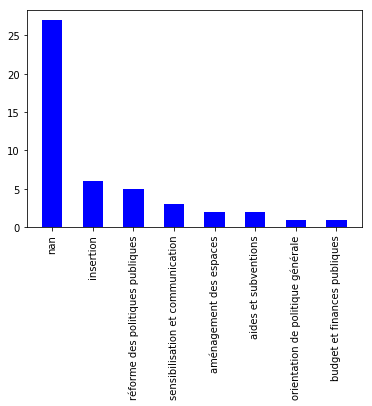



faciliter
[(nan, 36), ('insertion', 7), ('simplification', 6), ('réforme des politiques publiques', 3), ('orientation de politique générale', 2), ('aménagement des espaces', 2), ('sensibilisation et communication', 1), ('budget et finances publiques', 1), ('régulation des comportements', 1)]


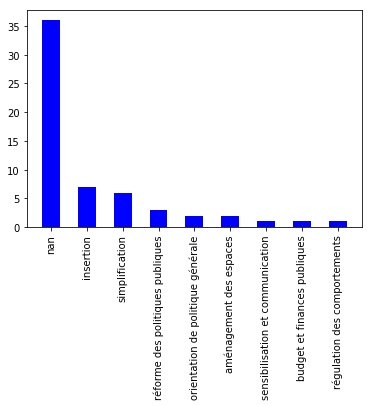



prendre
[(nan, 25), ('réforme des politiques publiques', 18), ('sensibilisation et communication', 6), ('aides et subventions', 1), ('solution non mentionnée', 1), ('régulation des comportements', 1)]


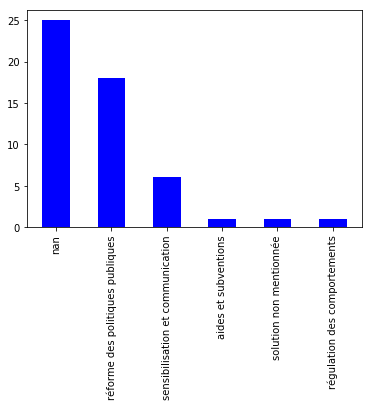



former
[(nan, 40), ('sensibilisation et communication', 15), ('réforme des politiques publiques', 5), ('insertion', 4), ('régulation des comportements', 1), ('aménagement des espaces', 1)]


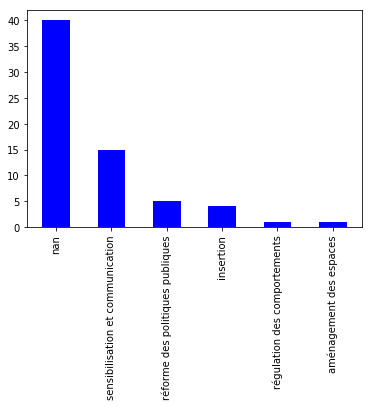



augmenter
[(nan, 25), ('budget et finances publiques', 7), ('réforme des politiques publiques', 3), ('harmonisation', 2), ('insertion', 1), ('sanctions et contrôle', 1), ('aides et subventions', 1), ('solution non mentionnée', 1), ('comportements individuels', 1), ('taxation', 1), ('aménagement des espaces', 1)]


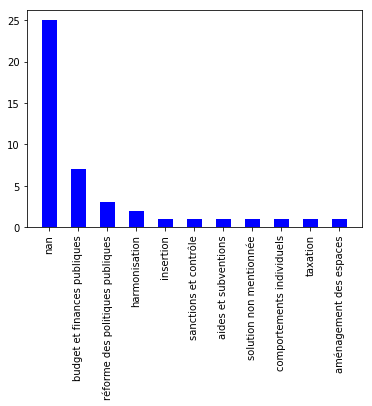



changer
[('sensibilisation et communication', 8), (nan, 6), ('comportements individuels', 1), ('insertion', 1)]


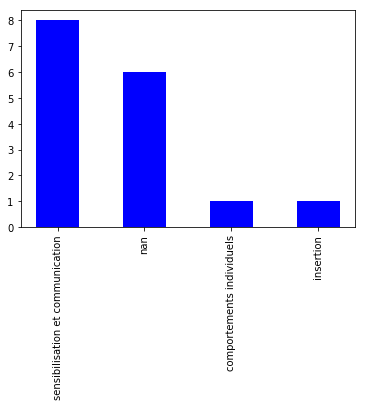



garantir
[(nan, 14), ('réforme des politiques publiques', 6), ('orientation de politique générale', 2), ('aménagement des espaces', 2), ('budget et finances publiques', 2), ('harmonisation', 1), ('régulation des comportements', 1), ('aides et subventions', 1)]


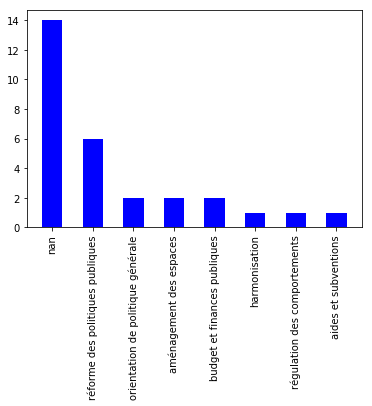



sensibiliser
[(nan, 20), ('sensibilisation et communication', 17), ('insertion', 4), ('sanctions et contrôle', 1)]


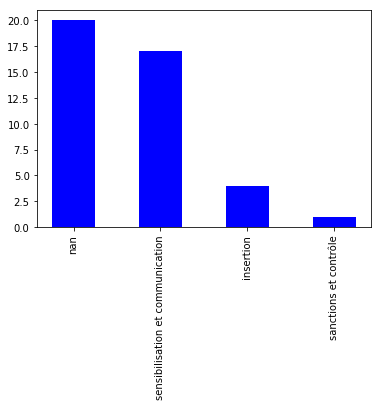



adapter
[(nan, 16), ('aménagement des espaces', 6), ('insertion', 3), ('sensibilisation et communication', 2)]


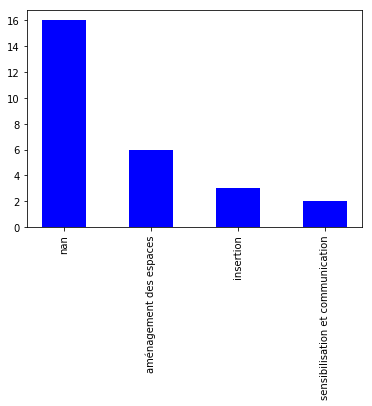



reconnaître
[(nan, 18), ('réforme des politiques publiques', 8), ('sensibilisation et communication', 1), ('aménagement des espaces', 1)]


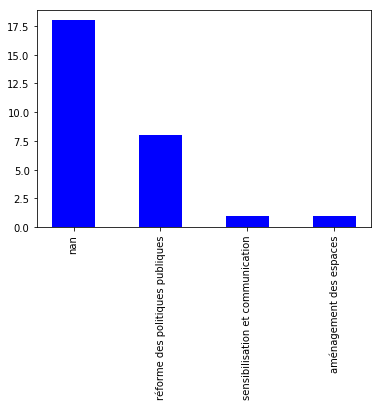



rendre
[(nan, 14), ('aménagement des espaces', 9), ('réforme des politiques publiques', 4), ('sensibilisation et communication', 3), ('budget et finances publiques', 3), ('régulation des comportements', 2), ('sanctions et contrôle', 1)]


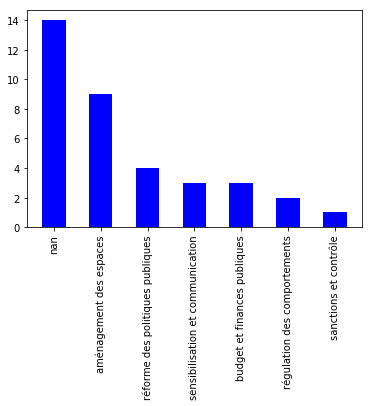



revoir
[(nan, 15), ('réforme des politiques publiques', 6), ('sensibilisation et communication', 2), ('simplification', 1)]


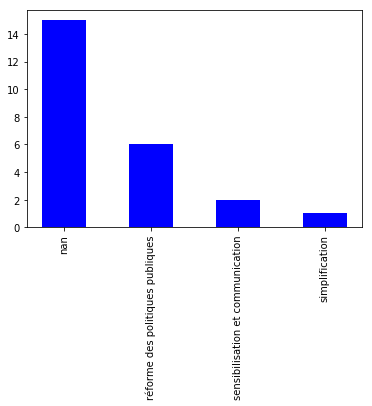



mettre
[(nan, 36), ('réforme des politiques publiques', 7), ('harmonisation', 3), ('sensibilisation et communication', 3), ('aides et subventions', 2), ('aménagement des espaces', 2), ('régulation des comportements', 2), ('budget et finances publiques', 1), ('orientation de politique générale', 1), ('participation citoyenne', 1), ('insertion', 1)]


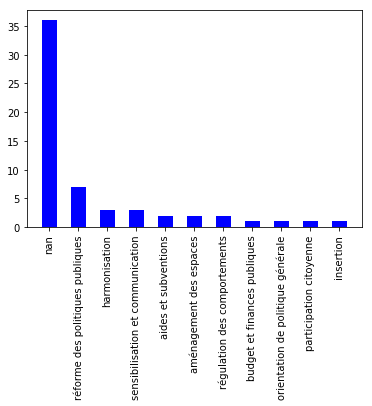



créer
[(nan, 54), ('réforme des politiques publiques', 9), ('aménagement des espaces', 6), ('sensibilisation et communication', 3), ('insertion', 2), ('orientation de politique générale', 2), ('participation citoyenne', 2), ('sanctions et contrôle', 1), ('harmonisation', 1), ('solution non mentionnée', 1), ('aides et subventions', 1)]


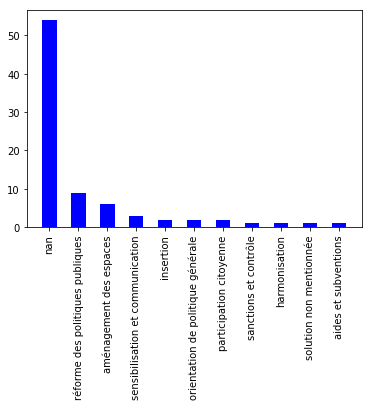



permettre
[(nan, 60), ('insertion', 9), ('réforme des politiques publiques', 6), ('aménagement des espaces', 4), ('aides et subventions', 3), ('orientation de politique générale', 2), ('solution non mentionnée', 2), ('simplification', 2), ('budget et finances publiques', 1), ('harmonisation', 1), ('sensibilisation et communication', 1)]


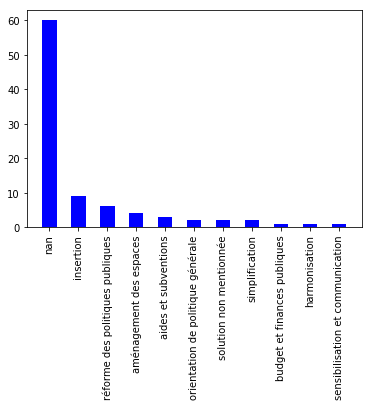



arrêter
[(nan, 38), ('réforme des politiques publiques', 8), ('sensibilisation et communication', 2), ('régulation des comportements', 2), ('simplification', 1), ('harmonisation', 1)]


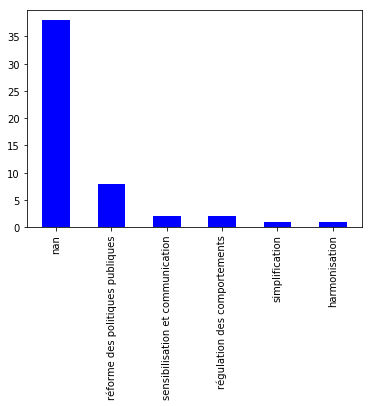



informer
[(nan, 11), ('sensibilisation et communication', 10)]


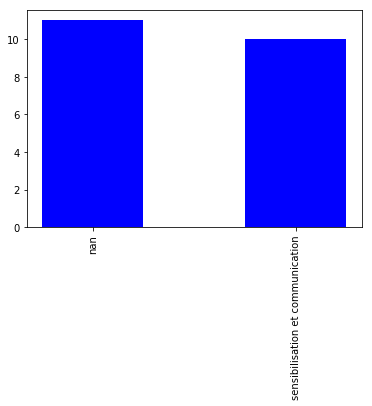



supprimer
[(nan, 8), ('réforme des politiques publiques', 7)]


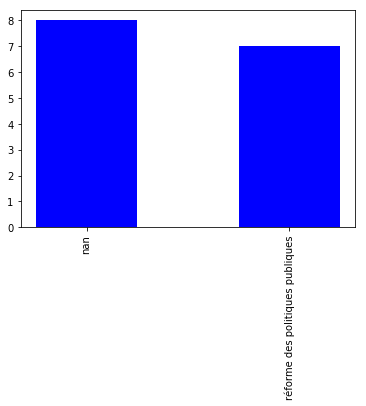

In [46]:
#solutions les plus fréquentes pour les keywords vp les plus présents
for k,v in vp2solutioncount.items() : 
    sortedsolution=sorted(vp2solutioncount[k].items(), key=lambda x: x[1], reverse=True)
    if(len(sortedsolution)>1):
        if (sortedsolution[1][1]>5) :
            print(k)
            print(sortedsolution)
            graphe = plt.figure()
            x = range(1,len(sortedsolution)+1)
            height = [j for i,j in sortedsolution]
            width = 0.5
            BarName =[i for i,j in sortedsolution]
            pylab.xticks(x, BarName, rotation=90)
            plt.bar(x, height, width, color='b')
            plt.show()
            print('\n')

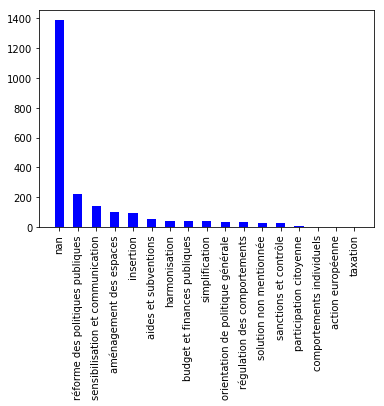

In [45]:
#nombre de proposition par solution
sortedsolutionscount=sorted(solutionscount.items(), key=lambda x: x[1], reverse=True)
graphe = plt.figure()
x = [i for i in range(len(solutionscount))]
height = [j for i,j in sortedsolutionscount]
width = 0.5
BarName =[i for i,j in sortedsolutionscount]
pylab.xticks(x, BarName, rotation=90)
plt.bar(x, height, width, color='b')
plt.show()
print('\n')

In [42]:
#wordcloud : principaux keywords par tag
stake2keywordcount=defaultdict(lambda:defaultdict(int))
for i in range(len(props)) : 
    stake=stakes[i]
    for word in set(annotspattern[props[i]]):
        stake2keywordcount[stake][word]+=1

In [43]:
#retire les mots clés apparaissant dans les top 50 de 3 tags ou plus
"""
countpresence=defaultdict(int)
for key in set(stakes) :
    if not isinstance(key,float) :
        s=sorted(stake2keywordcount[key].items(), key=lambda x: x[1], reverse=True)
        for kw,count in s[:50] : 
            countpresence[kw]+=1
for k,v in countpresence.items() : 
    if v>2 : 
        for st in set(stakes) :
            if k in stake2keywordcount[st].keys() : 
                del stake2keywordcount[st][k]"""

nan


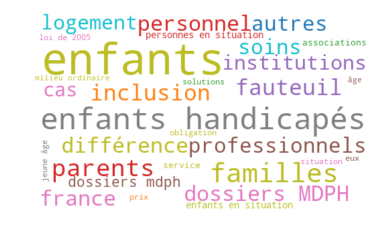

éducation


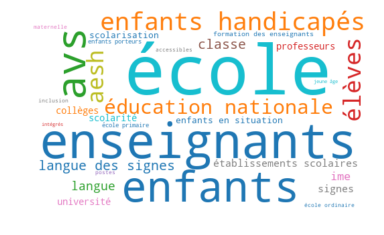

travail


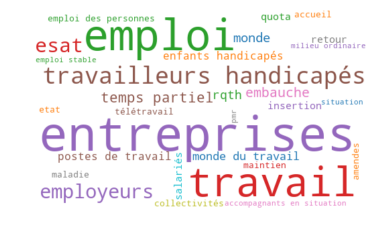

allocations et financier


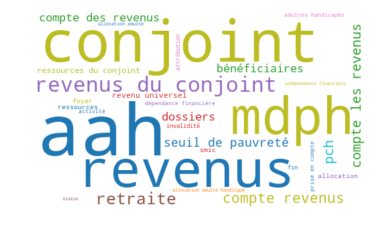

accessibilité et mobilité


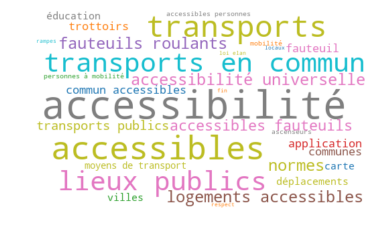

aidants


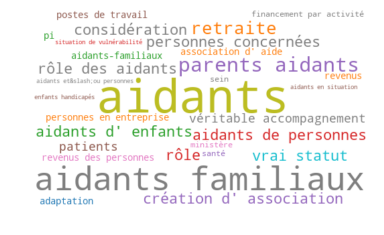

prise en charge


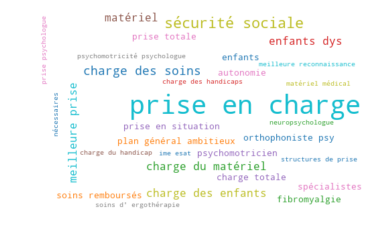

handicaps invisibles


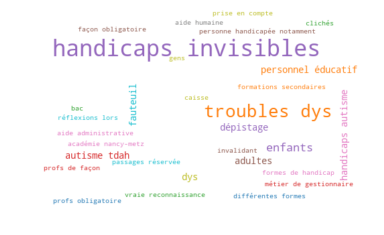

changement regard


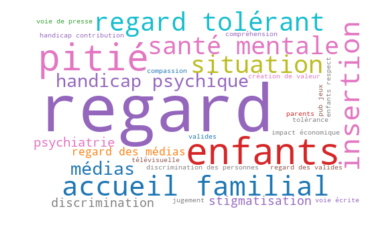

In [5]:
sortedstakescount=sorted(stakescount.items(), key=lambda x: x[1], reverse=True)
for key,value in sortedstakescount :
    print(key)
    #wordcloud des keywords les plus présents par tag
    wordcloudkeyword = wordcloud.WordCloud(colormap="tab10",background_color="white",width=500,height=300, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(stake2keywordcount[key])
    plt.figure()
    plt.imshow(wordcloudkeyword,interpolation='bilinear')
    plt.axis("off")
    plt.show()

quel tag ?
accessibilité et mobilité


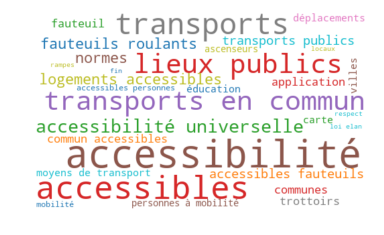

In [9]:
#wordcloud des keywords les plus présents pour un tag donné
print("quel tag ?")
key=input()
wordcloudkeyword = wordcloud.WordCloud(colormap="tab10",background_color="white",width=500,height=300, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(stake2keywordcount[key])
plt.imshow(wordcloudkeyword,interpolation='bilinear')
plt.axis("off")
wordcloudkeyword.to_file('wordcloud__.png')
plt.show()